In [1]:
import pandas as pd
import numpy as np

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.graphics.tsaplots as tsg
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA

from datetime import datetime, date

In [2]:
df_raw = pd.read_csv('./data/00_original/Lake_Bilancino.csv', sep=',', header=0, index_col=0)

df = df_raw[['Lake_Level']].copy()
df.index = pd.to_datetime(df.index, format = '%d/%m/%Y')
df = df.asfreq('d')
df.head(5)

,Lake_Level
Date,
2002-06-03,249.43
2002-06-04,249.43
2002-06-05,249.43
2002-06-06,249.43
2002-06-07,249.44


In [3]:
df['Lake_Level'] -= (251 - 31)
print(df.isna().sum())

Lake_Level    0
dtype: int64


<AxesSubplot:xlabel='Date'>

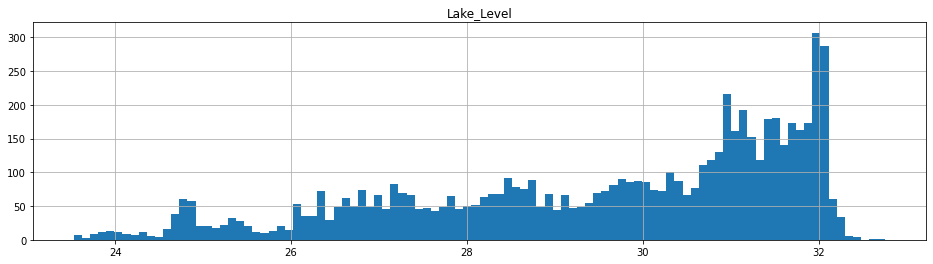

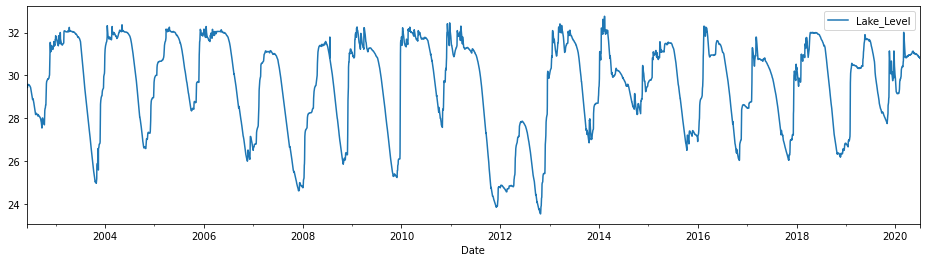

In [4]:
df.hist(figsize=(16, 4), bins=100)
df.plot(figsize=(16, 4))

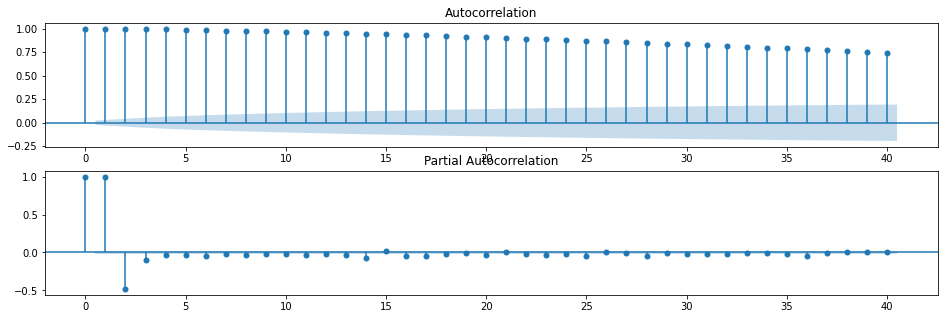

In [5]:
# SEASONALITY CHECK

fig, ax = plt.subplots(2, 1, figsize=(16, 5))

tsg.plot_acf(df['Lake_Level'],lags=40, ax=ax[0])
tsg.plot_pacf(df['Lake_Level'],lags=40, ax=ax[1])
plt.show()

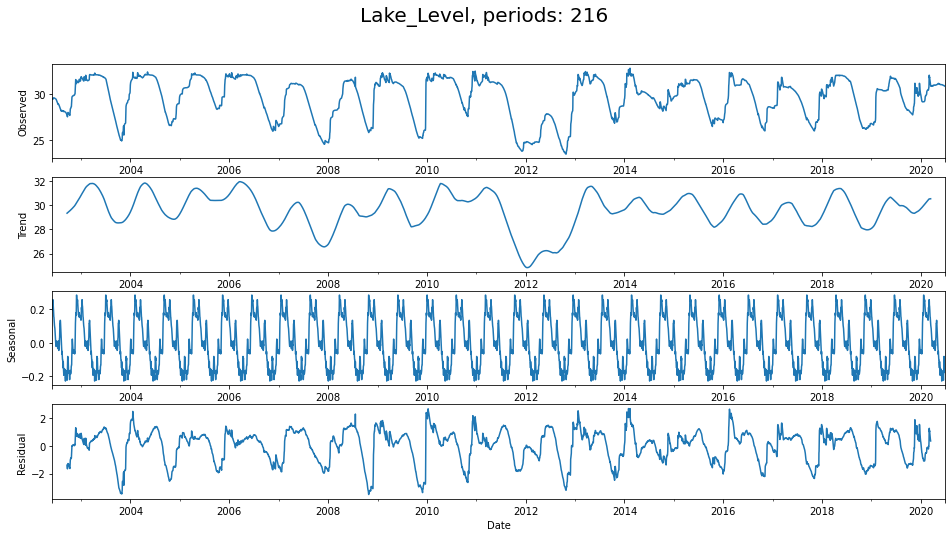

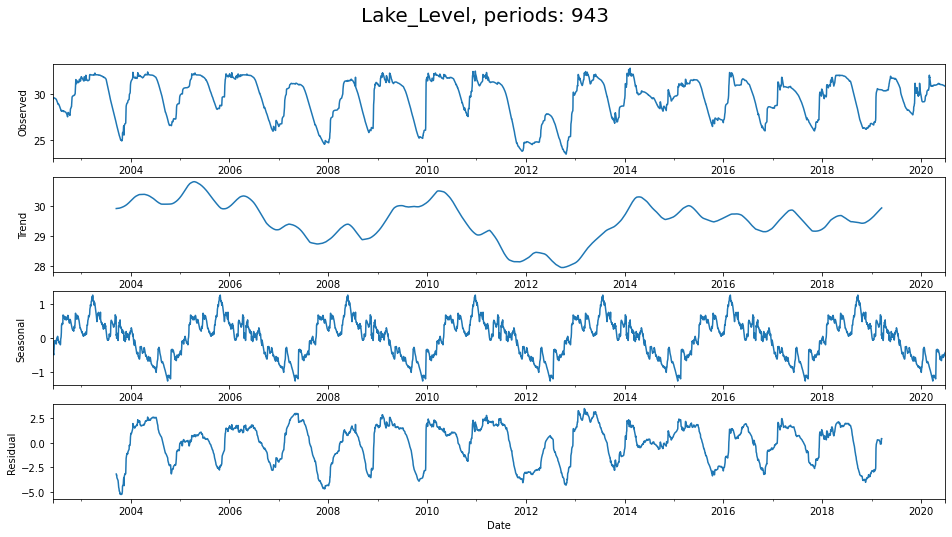

In [6]:
months = int(((max(df.index) - min(df.index))/np.timedelta64(1, 'M')))
weeks = int(((max(df.index) - min(df.index))/np.timedelta64(1, 'W')))

def seasonal_decompose_plot(series, periods):
    result = seasonal_decompose(series, model='additive', period=periods)

    fig, ax = plt.subplots(4,1, figsize=(16, 8))
    
    fig.suptitle('{}, periods: {}'.format(series.name, periods), size=20)

    result.observed.plot(ax=ax[0])
    ax[0].set_ylabel('Observed')
    result.trend.plot(ax=ax[1])
    ax[1].set_ylabel('Trend')
    result.seasonal.plot(ax=ax[2]) # blue square = no cyclical pattern because value is constantly jumping up and down
    ax[2].set_ylabel('Seasonal')
    result.resid.plot(ax=ax[3])
    ax[3].set_ylabel('Residual')
    
seasonal_decompose_plot(df['Lake_Level'], months)
seasonal_decompose_plot(df['Lake_Level'], weeks)

Dickey-Fuller Test for "Lake_Level":
	 ADF = -6.881605581861189
	   p = 1.4287290613085007e-09
	data IS stationary


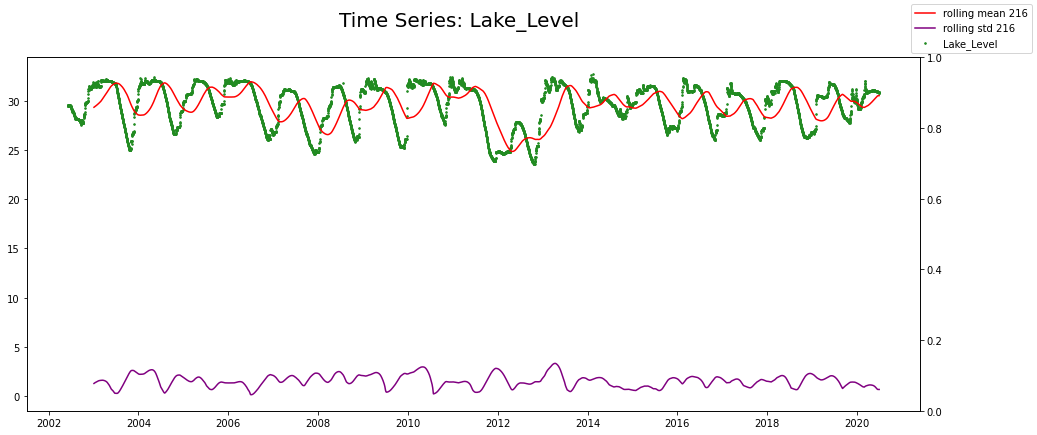

In [19]:
# STATIONARITY
# Stationarity check means that we have constant mean and variance of the data over the time.
# We can inspect visually or use Dickey-Fuller statistical test.

# Dickey-Fuller statisticall test:
# Is trying to reject the null hypothesis that the data is non-stationary.
# If we reject the test means that data is stationary
#    if p <= 0.05 we reject the null hypothesis and data is stationary
#    if p >  0.05 we accept the null hypothesis and data is non-stationary

def testDickeyFuller(series, rolling_interval):
    adf_test_result = sts.adfuller(series.values)
    
    significance_level = 0.05
    adf = adf_test_result[0]
    pValue = adf_test_result[1]
    threshold_1 = adf_test_result[4]['1%']
    threshold_5 = adf_test_result[4]['5%']
    threshold_10 = adf_test_result[4]['10%']
    
    print('Dickey-Fuller Test for "{}":'.format(series.name))
    print('\t ADF = {}'.format(str(adf)))
    print('\t   p = {}'.format(str(pValue)))
    
    color = 'purple'
    if (pValue < significance_level) & (adf < threshold_1):
        color = 'forestgreen' 
        print('\tdata IS stationary & p < []adf < 1%')
    elif (pValue < significance_level) & (adf < threshold_5):
        color = 'orange'
        print('\tdata IS stationary & adf < 5%')
    elif (pValue < significance_level) & (adf < threshold_10):
        color = 'red'
        print('\tdata IS stationary & adf < 10%')
    else:
        print('\tdata NOT stationary')
        
    fig, ax = plt.subplots(1, 1, figsize=(16, 6.5))
    
    fig.suptitle('Time Series: {}'.format(series.name), size=20)
    
    ax.scatter(x=df.index, y=series, color=color, label=series.name, marker='.', s=10, alpha=1)
    ax2 = ax.twinx()

    ax.plot(series.rolling(rolling_interval).mean(), color='red', label='rolling mean {}'.format(rolling_interval))
    ax.plot(series.rolling(rolling_interval).std(), color='purple', label='rolling std {}'.format(rolling_interval))
    fig.legend()

testDickeyFuller(df['Lake_Level'], months)

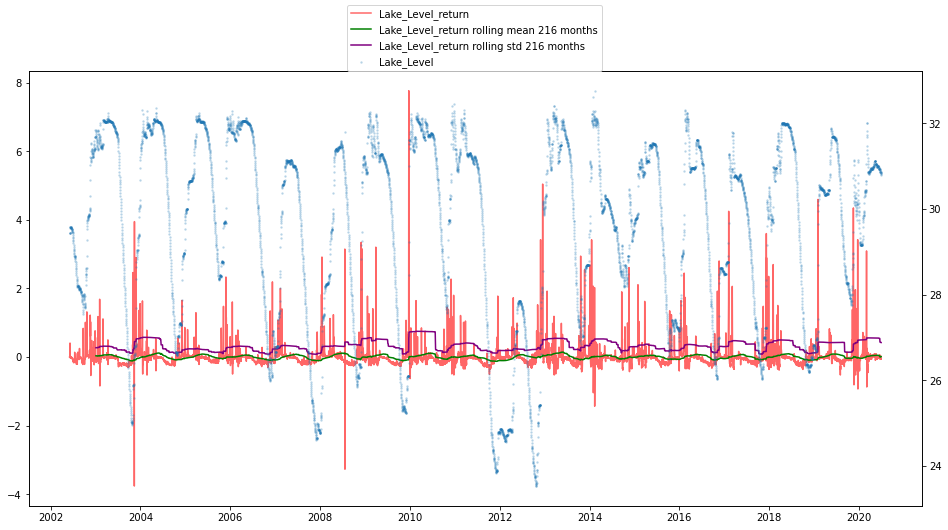

In [8]:
# Because lake level is not stationary we need to transform it to returns and then plot mean and std

df['Lake_Level_return'] = df['Lake_Level'].pct_change(1).mul(100)
df = df.dropna()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(df['Lake_Level_return'], color='red', alpha=0.6, label='Lake_Level_return')
ax.plot(df['Lake_Level_return'].rolling(months).mean(), color='green', label='Lake_Level_return rolling mean {} months'.format(months))
ax.plot(df['Lake_Level_return'].rolling(months).std(), color='purple', label='Lake_Level_return rolling std {} months'.format(months))

ax2 = ax.twinx()
ax2.scatter(x=df.index, y=df['Lake_Level'], label='Lake_Level', marker='.', s=10, alpha=0.2)

fig.legend(loc='upper center')

Dickey-Fuller Test for "Lake_Level_return":
	 ADF = -11.342444963765292
	   p = 1.0465264217696878e-20
	data IS stationary


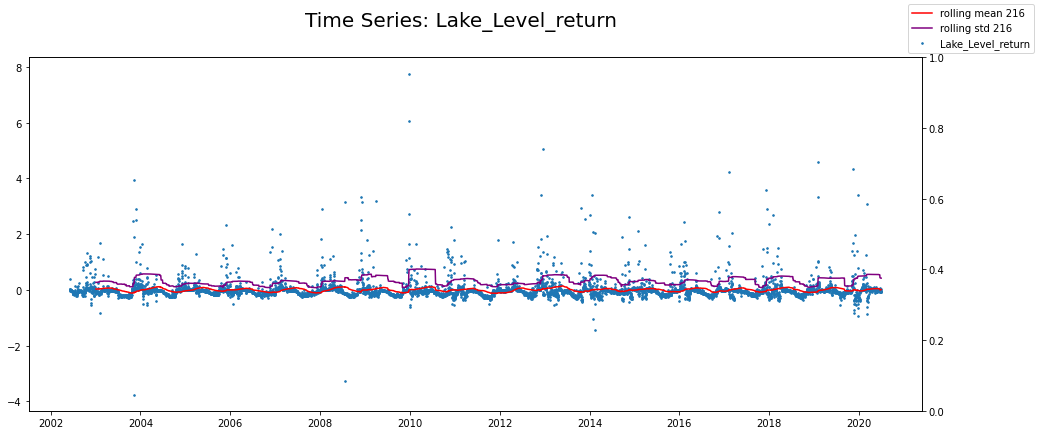

In [9]:
testDickeyFuller(df['Lake_Level_return'], months)

            Lake_Level  Lake_Level_return
Date                                     
2016-11-13       26.94           0.111483
2016-11-14       26.96           0.074239
2016-11-15       26.98           0.074184
2016-11-16       26.98           0.000000
2016-11-17       26.99           0.037064
            Lake_Level  Lake_Level_return
Date                                     
2016-11-18       27.00           0.037051
2016-11-19       27.50           1.851852
2016-11-20       28.27           2.800000
2016-11-21       28.39           0.424478
2016-11-22       28.45           0.211342


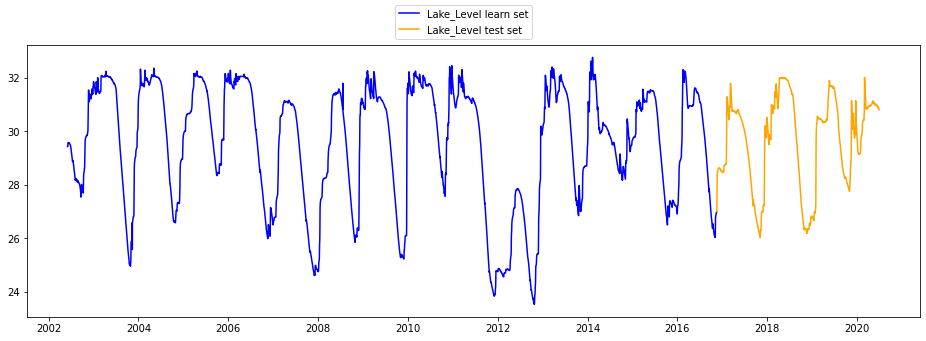

In [10]:
test_percentage = 0.2

split = int(len(df) * (1 - test_percentage))
df_learn = df.iloc[:split]
df_test = df.iloc[split:]

fig, ax = plt.subplots(1, 1, figsize=(16, 5))

ax.plot(df_learn['Lake_Level'], color='blue', label='Lake_Level learn set')
ax.plot(df_test['Lake_Level'], color='orange', label='Lake_Level test set')
fig.legend(loc='upper center');

print(df_learn.tail(5))
print(df_test.head(5))

In [11]:
# from statsmodels.tsa.arima.model import ARIMA

# model = ARIMA(df_learn['Lake_Level'], order=(4,1,0))
# model_fit = model.fit()

# # print(model_fit.summary())


# # predictions=model_fit.forecast(len(df_test['Lake_Level']))
# # model_fit.plot_predict(264)

# # predictions.plot()

# # fig, ax = plt.subplots(1, 1, figsize=(16, 5))

# # ax.plot(df_learn['Lake_Level'], color='blue', label='Lake_Level learn set')
# # ax.plot(df_test['Lake_Level'], color='orange', label='Lake_Level test set')
# # ax.plot(, color='red', label='Prediction')
# # fig.legend(loc='upper center');